In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../qdmt/')

In [3]:
from uMPSHelpers import *
from hamiltonian import TransverseIsing
from vumps import vumps 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm import tqdm

In [5]:
def getOverlap(A, B):
    D, d, _ = A.shape
    TM = ncon([A, B.conj()], ((-1, 1, -3), (-2, 1, -4))).reshape(D*D, D*D)
    Lambda,R = eigs(TM,k=1,which='LM')
    return np.abs(Lambda)

In [6]:
def get_TTrotter(A,B,U,U2,d,D):
    """Gives the time-evolved transfer matrix. TAU[ D,d,d,d,D,d,d,d]
    This is for the first of the Z2 choices"""

    """ Construct the mixed transfer matrix """
    T = ncon([A,A,U,U2,U,B.conj(),B.conj()],\
    ([-1, -2, 1],[1, 2, -7],\
    [-3, 3, 2, -8],[4, -10, 3, -9],[5, -11, -4, 4],\
    [-6, -5, 6],[6, 5, -12]))
    T = T.reshape([D**2*d**4, D**2*d**4])
    Lambda,R = eigs(T,k=1,which='LM')
    return Lambda

In [7]:
def get_halfTrotter(A, B, U):
    D, d, _ = A.shape
    TM = ncon([A, A, U, B.conj(), B.conj()],\
              ((-1, 1, 3), (3, 5, -3),\
               (2, 6, 1, 5),\
               (-2, 2, 4), (4, 6, -4))).reshape(D**2, D**2)
    Lambda,R = eigs(TM,k=1,which='LM')
    return Lambda

In [8]:
g1 = 1.5
g2 = 0.2
D = 4
d = 2

In [9]:
# Prepare the ground state
h1 = TransverseIsing(1, g1, 2).reshape(d, d, d, d)
Al, Ac, Ar, C = vumps(h1, D, d, tol=1e-8, tolFactor=1e-2, verbose=True)

iteration: 1
   energy: -0.15165148268457262
   error: 0.15265269819928956
   errorL: 0.0025695736186852817
   errorR: 0.004782948201650511
iteration: 2
   energy: -0.00045437623302667027
   error: 0.002082660475595722
   errorL: 0.00037490171754745583
   errorR: 0.0007223341813266338
iteration: 3
   energy: -3.195341870678575e-05
   error: 0.00035758420396206657
   errorL: 5.022232740354917e-05
   errorR: 7.141040903947808e-05
iteration: 4
   energy: -4.904262955116034e-07
   error: 7.371903760064264e-05
   errorL: 9.682404516050515e-06
   errorR: 1.0889404696970532e-05
iteration: 5
   energy: -2.6079028530440196e-08
   error: 1.536583191937256e-05
   errorL: 1.9826242518123714e-06
   errorR: 2.0611831553894817e-06
iteration: 6
   energy: -2.257468247057748e-09
   error: 3.194457160596733e-06
   errorL: 4.1060736876922575e-07
   errorR: 4.170079747463395e-07
iteration: 7
   energy: -2.1186573329057268e-10
   error: 6.623886656070094e-07
   errorL: 8.50797484659098e-08
   errorR: 8.567

In [10]:
A0 = np.copy(Al)

Now do time evolution

In [11]:
h2 = TransverseIsing(1, g2, 2)
dt = 0.1
U = expm(-1j*h2*dt*2).reshape(d, d, d, d)

In [12]:
def tevCostFunction(B, A, U):
    l = len(B)
    B = B[:l//2] + 1j*B[l//2:]
    D, d, _ = A.shape
    B = B.reshape(D, d, D)
    B, _, _, _ = mixedCanonical(B)
    B = normalizeMPS(B)
    return np.abs(get_halfTrotter(A, B, U))

In [13]:
from scipy.optimize import minimize
from vumpt_tools import mixedCanonical

In [15]:
At = np.copy(A0)
ts = np.arange(0.0, 1.5, dt)
loverlaps = [getOverlap(A0, At)]
Ats = [At]
for t in tqdm(ts[1:]):
    x0 = At.flatten()
    x0 = np.concatenate((np.real(x0), np.imag(x0)))
    res = minimize(tevCostFunction, x0=x0, args=(A0, U), method='Nelder-Mead', options={'maxiter':5000})
    xdt = res.x
    Adt = xdt[:D*d*D] + 1j*xdt[D*d*D:]
    Adt = Adt.reshape(D, d, D)
    Adt, _, _, _ = mixedCanonical(Adt)
    Adt = normalizeMPS(Adt)

    
    loverlaps.append(getOverlap(A0, Adt))
    Ats.append(Adt)
    At = Adt

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [20:17<00:00, 86.99s/it]


In [16]:
losch = -1*np.log(loverlaps)

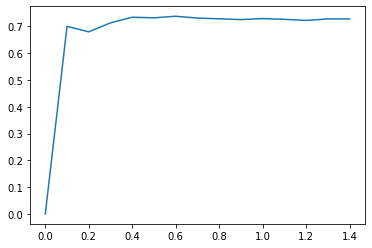

In [17]:
plt.plot(ts, losch)